In [2]:
####################
### Dependencies ###
####################

import requests as rq
from dotenv import load_dotenv
import os
import json
import pandas as pd
from io import StringIO
from IPython.display import display
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import sqlite3 as sql
import psycopg as pg
import asyncio
import nest_asyncio
from scipy.stats import norm
import numpy as np
import subprocess

In [3]:
#####################
### General Setup ###
#####################

nest_asyncio.apply()
load_dotenv()

True

In [11]:
#################################
### Import data into Postgres ###
#################################

import_file = "/home/tev/Documents/precincts-with-results.geojson"
command = "/nix/store/v2qqya4p0fy042a260jq1lgbzvim4wpc-gdal-3.9.2/bin/ogr2ogr"
POSTGRES_DB = os.getenv("POSTGRES_DB")
POSTGRES_USER = os.getenv("POSTGRES_USER")
POSTGRES_PASSWORD = os.getenv("POSTGRES_PASSWORD")
POSTGRES_ENDPOINT = os.getenv("POSTGRES_ENDPOINT")
r = subprocess.run([command, "-f", "PostgreSQL", f"PG:host={POSTGRES_ENDPOINT} dbname={POSTGRES_DB} user={POSTGRES_USER} password={POSTGRES_PASSWORD}", import_file, "-nln", POSTGRES_DB, "-nlt", "PROMOTE_TO_MULTI"])
r.returncode

0

In [14]:
##################################
### Setup PostgreSQL Constants ###
##################################

# Make a connection to the database
activateCon = lambda : pg.Connection.connect(os.getenv("DB_URI"), cursor_factory=pg.ClientCursor)
con = activateCon()
cur = con.cursor()

In [12]:
###########################
### Setup PostgreSQL DB ###
###########################

# Initialize transformed tables AFTER IMPORTING THE GEOJSON FILE
cur.execute('''
    CREATE TABLE transformed AS
    SELECT
        ogc_fid AS id,
        ST_CollectionExtract(ST_MakeValid(ST_GeomFromWKB(wkb_geometry))) AS geo,
        substring(geoid from 1 for 2)::INT AS state,
        substring(geoid from 3 for 3)::INT AS county,
        votes_dem AS dem,
        votes_rep AS rep,
        votes_total AS total
    from jerry;

    INSERT INTO meta (state, type, level)
        SELECT state, 0, 0
        FROM transformed
        GROUP BY state;

    INSERT INTO groups (runid, geo, dem, rep, total)
        SELECT m.runid, t.geo, COALESCE(t.dem, 0), COALESCE(t.rep, 0), COALESCE(t.total, 0)
        FROM transformed AS t
        JOIN meta AS m ON t.state = m.state;
''')
con.commit()
con.close()

In [6]:
con = activateCon()
cur = con.cursor()

cur.execute('''
    SELECT * FROM meta;
''').fetchall()



[(1, 44, 0, None, 0, None),
 (2, 11, 0, None, 0, None),
 (3, 42, 0, None, 0, None),
 (4, 40, 0, None, 0, None),
 (5, 9, 0, None, 0, None),
 (6, 15, 0, None, 0, None),
 (7, 48, 0, None, 0, None),
 (8, 26, 0, None, 0, None),
 (9, 19, 0, None, 0, None),
 (10, 30, 0, None, 0, None),
 (11, 21, 0, None, 0, None),
 (12, 17, 0, None, 0, None),
 (13, 37, 0, None, 0, None),
 (14, 28, 0, None, 0, None),
 (15, 5, 0, None, 0, None),
 (16, 56, 0, None, 0, None),
 (17, 54, 0, None, 0, None),
 (18, 29, 0, None, 0, None),
 (19, 4, 0, None, 0, None),
 (20, 34, 0, None, 0, None),
 (21, 10, 0, None, 0, None),
 (22, 35, 0, None, 0, None),
 (23, 45, 0, None, 0, None),
 (24, 6, 0, None, 0, None),
 (25, 39, 0, None, 0, None),
 (26, 36, 0, None, 0, None),
 (27, 31, 0, None, 0, None),
 (28, 50, 0, None, 0, None),
 (29, 13, 0, None, 0, None),
 (30, 16, 0, None, 0, None),
 (31, 41, 0, None, 0, None),
 (32, 46, 0, None, 0, None),
 (33, 53, 0, None, 0, None),
 (34, 32, 0, None, 0, None),
 (35, 38, 0, None, 0, None)

In [13]:
data = data = pd.DataFrame({"index": np.arange(0, 100, 1),"Blue": np.random.normal(7, 1.5, 100), "Red": np.random.normal(81, 1.5, 100)})

In [15]:
id = con.execute("select create_layers('{{880, 4}, {88, 4}}', 25);").fetchall()[0][0]
data = pd.DataFrame(con.execute("select * from results where resid = "+ str(id) + ";").fetchall())

con.commit()
con.close()

Red_mean, Red_std:  78.3125 1.4930394055974097
Blue_mean, Blue_std:  10.6875 1.4930394055974097


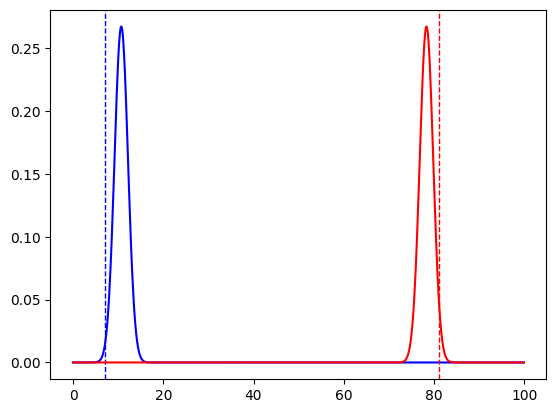

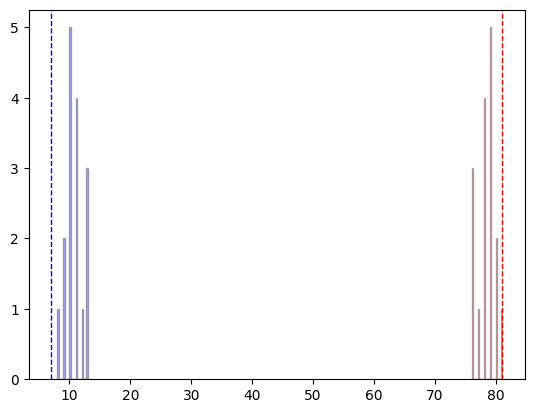

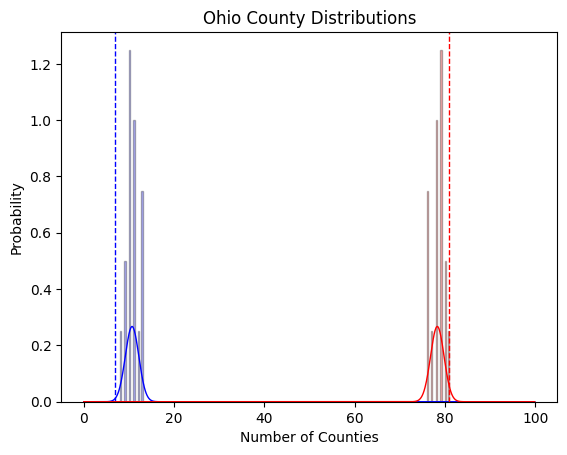

In [17]:
x_axis = np.arange(0, 100, 0.1)
bins = 20

columns = data.columns

blue_mean = data[columns[2]].mean()
blue_std = data[columns[2]].std()
actual_blue= 7    # placeholder

red_mean = data[columns[3]].mean()
red_std = data[columns[3]].std()
actual_red= 81    # placeholder

print("Red_mean, Red_std: ", red_mean, red_std)
print("Blue_mean, Blue_std: ", blue_mean, blue_std)

#normal distributions
plt.plot(x_axis, norm.pdf(x_axis, loc=blue_mean, scale=blue_std), color='b')
plt.axvline(x=actual_blue, color='b', linestyle='dashed', linewidth=1)
plt.plot(x_axis, norm.pdf(x_axis, loc=red_mean, scale=red_std), color='r')
plt.axvline(x=actual_red, color='r', linestyle='dashed', linewidth=1)
plt.figure()


#histogram plot
plt.axvline(x=actual_blue, color='b', linestyle='dashed', linewidth=1)
plt.axvline(x=actual_red, color='r', linestyle='dashed', linewidth=1)
plt.hist(data[columns[2]], bins=bins, color='b', alpha=0.3, edgecolor='black')
plt.hist(data[columns[3]], bins=bins, color='r', alpha=0.3, edgecolor='black')
plt.figure()

#combined plot
plt.hist(data[columns[2]], bins=bins, color='b', density=True, alpha=0.3, edgecolor='black')
plt.hist(data[columns[3]], bins=bins, color='r', density=True, alpha=0.3, edgecolor='black')
plt.plot(x_axis, norm.pdf(x_axis, loc=data[columns[2]].mean(), scale=data[columns[2]].std()), color='b', linewidth=1)
plt.axvline(x=actual_blue, color='b', linestyle='dashed', linewidth=1)
plt.plot(x_axis, norm.pdf(x_axis, loc=data[columns[3]].mean(), scale=data[columns[3]].std()), color='r', linewidth=1)
plt.axvline(x=actual_red, color='r', linestyle='dashed', linewidth=1)
plt.title("Ohio County Distributions")
plt.xlabel("Number of Counties")
plt.ylabel("Probability")
plt.show()